# Домашнее задание. Урок 1. Основы обучения нейронных сетей

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [197]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

### Шаг 1. Определение функций, которые понадобяться для обучения

In [198]:
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized


# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if (l[j] == 1):
                arr[i] = j + 1
    return arr


# сигмоида и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_deriv(x):
    return (x) * (1 - (x))


# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

### Шаг 2. Подготовка тренировочных данных

In [199]:
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
iris_data.head()  # расскоментируйте, чтобы посмотреть структуру данных

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Ирисы Фишера — это набор данных для задачи классификации, на примере которого Рональд Фишер в 1936 году продемонстрировал работу разработанного им метода дискриминантного анализа.[1] Иногда его также называют ирисами Андерсона, так как данные были собраны американским ботаником Эдгаром Андерсоном.[2] Этот набор данных стал уже классическим, и часто используется в литературе для иллюстрации работы различных статистических алгоритмов.[3]
[https://ru.wikipedia.org/wiki/Ирисы_Фишера](https://ru.wikipedia.org/wiki/Ирисы_Фишера)

Ирисы Фишера состоят из данных о 150 экземплярах ириса, по 50 экземпляров из трёх видов:
- Ирис щетинистый (Iris setosa),
- Ирис виргинский (Iris virginica),
- Ирис разноцветный (Iris versicolor).

Для каждого экземпляра измерялись четыре характеристики (в сантиметрах):
1. Длина наружной доли околоцветника (англ. sepal length);
2. Ширина наружной доли околоцветника (англ. sepal width);
3. Длина внутренней доли околоцветника (англ. petal length);
4. Ширина внутренней доли околоцветника (англ. petal width).


In [200]:
FEATURES = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
RESULTS = 'Species'
dict_results = ['Iris-setosa', 'Iris-virginica', 'Iris-versicolor']

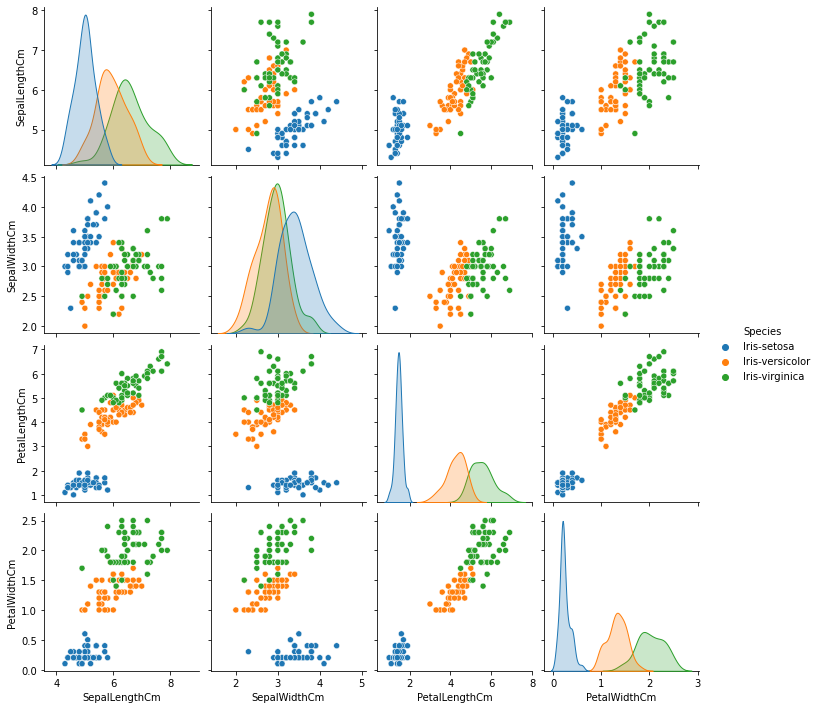

In [201]:
# репрезентация данных в виде графиков
sns.pairplot(iris_data.drop("Id", axis=1), hue=RESULTS)

In [202]:
# замена текстовых значений на цифровые
iris_data[RESULTS].replace(dict_results, list(range(0, len(dict_results))), inplace=True)

In [203]:
# формирование входных данных
x = pd.DataFrame(iris_data, columns=FEATURES)
x = normalize(x.values)

# формирование выходных данных(результатов)
y = pd.DataFrame(iris_data, columns=[RESULTS])
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [220]:
print(x.shape)
print(y.shape)

(150, 4)
(150, 3)


In [217]:
x[:5]

array([[0.80377277, 0.55160877, 0.22064351, 0.0315205 ],
       [0.82813287, 0.50702013, 0.23660939, 0.03380134],
       [0.80533308, 0.54831188, 0.2227517 , 0.03426949],
       [0.80003025, 0.53915082, 0.26087943, 0.03478392],
       [0.790965  , 0.5694948 , 0.2214702 , 0.0316386 ]])

In [218]:
y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

### Шаг 3. Обученние нейронной сети

Перепишем функцию в ООП стиль

In [206]:
class Neuro_1:
    # массив для ошибок, чтобы потом построить график
    errors = []
    # массив весов
    w = []
    # массив слоев
    layer = []
    accuracy = 0
    outs = None

    def __init__(self, neuron_numb=3, learning_rate=0.05, num_epochs=10000):
        self.set_params(neuron_numb=neuron_numb, learning_rate=learning_rate, num_epochs=num_epochs)

    def set_params(self, neuron_numb=3, learning_rate=0.05, num_epochs=10000):
        # neuron_numb определим число нейронов скрытого слоя
        self.neuron_numb = neuron_numb
        # скорость обучения (learning rate)
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.w = []
        self.errors = []
        self.layer = []
        self._generate_weights()

    def _generate_weights(self):
        self.w = []
        self.w.append(2 * np.random.random((4, self.neuron_numb)) - 1)  # для входного слоя   - 4 входа, 3 выхода
        self.w.append(2 * np.random.random((self.neuron_numb, 3)) - 1)  # для внутреннего слоя - 5 входов, 3 выхода

    def fit(self, X, y):
        layer0 = X

        # процесс обучения
        for i in range(self.num_epochs):
            # прямое распространение(feed forward)
            layer1 = self.sigmoid(np.dot(layer0, self.w[0]))
            layer2 = self.sigmoid(np.dot(layer1, self.w[1]))

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer2_error = y - layer2  # производная функции потерь = производная квадратичных потерь
            layer2_delta = layer2_error * self.sigmoid_deriv(layer2)

            layer1_error = layer2_delta.dot(self.w[1].T)
            layer1_delta = layer1_error * self.sigmoid_deriv(layer1)
            # коррекция
            self.w[1] += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w[0] += layer0.T.dot(layer1_delta) * self.learning_rate
            # метрика модели
            error = np.mean(np.abs(layer2_error))
            self.errors.append(error)
            self.accuracy = (1 - error) * 100

        self.outs = layer2

    def predict(self, x):
        layer0_t = x
        layer1_t = self.sigmoid(np.dot(layer0_t, self.w[0]))
        layer2_t = self.sigmoid(np.dot(layer1_t, self.w[1]))
        return layer2_t

    # сигмоида и ее производная
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_deriv(x):
        return (x) * (1 - (x))

    @staticmethod
    def calculate_accuracy_percent(y_predict, y_test):
        layer2_error_t = y_test - y_predict
        # метрика модели
        error_t = np.mean(np.abs(layer2_error_t))
        accuracy_t = (1 - error_t) * 100
        return round(accuracy_t, 2)

Протестируем на параметрах по умолчанию

In [207]:
neuro1 = Neuro_1()
neuro1.fit(X_train, y_train)

In [208]:
neuro1.accuracy

97.88995869680335

In [209]:
neuro1.w

[array([[ -0.33495868, -16.39302377,   4.0624555 ],
        [ -5.51867575, -11.61558839,   4.25326432],
        [  8.94199131,  21.89029876,  -8.96506545],
        [  2.83785298,  16.73187961,  -5.72319532]]),
 array([[ -6.49736842,  -6.68667876,  11.34956007],
        [ -8.69162557,  19.46383746, -22.22452253],
        [  6.99456355, -14.81190955,  -8.46447787]])]

### Шаг 4. Демонстрация полученных результатов


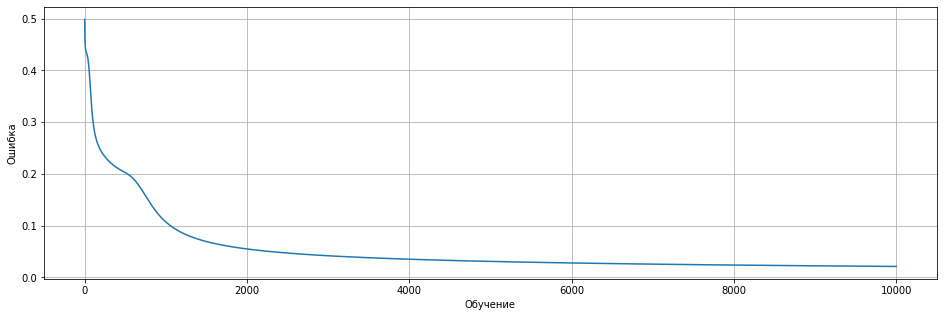

In [210]:
errors = neuro1.errors
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()
plt.show()  # расскоментируйте, чтобы посмотреть

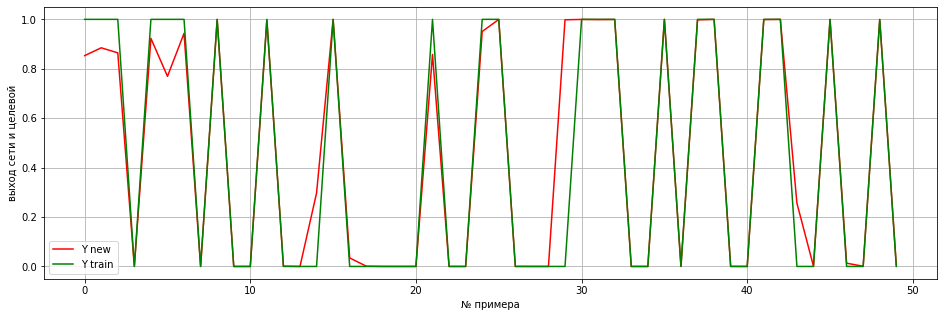

In [211]:
layer2 = neuro1.outs
N = 50
plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 1], 'r', label='Y new')
plt.plot(y_train[:N, 1], 'g', label='Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend()
plt.grid()
plt.show()  # расскоментируйте, чтобы посмотреть


### Проведем поиск оптимального решения по сетке

In [212]:
%time

grid_param = dict(neuron_numb=[3, 5, 10, 20], learning_rate=[0.1, 0.05, 0.01], num_epochs=[5000, 10000, 20000])
neuro1_1 = Neuro_1()
for nnum in grid_param['neuron_numb']:
    for lrate in grid_param['learning_rate']:
        for nep in grid_param['num_epochs']:
            neuro1_1.set_params(neuron_numb=nnum, learning_rate=lrate, num_epochs=nep)
            neuro1_1.fit(X_train, y_train)
            print(
                f' Количество нейронов: {nnum:2}, Скорость обучения: {lrate:5}, Количество эпох: {nep}, Точность - {neuro1_1.accuracy}')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 14.1 µs
 Количество нейронов:  3, Скорость обучения:   0.1, Количество эпох: 5000, Точность - 97.74461784625704
 Количество нейронов:  3, Скорость обучения:   0.1, Количество эпох: 10000, Точность - 98.39217560516033
 Количество нейронов:  3, Скорость обучения:   0.1, Количество эпох: 20000, Точность - 98.77767366672335
 Количество нейронов:  3, Скорость обучения:  0.05, Количество эпох: 5000, Точность - 96.8741746288423
 Количество нейронов:  3, Скорость обучения:  0.05, Количество эпох: 10000, Точность - 97.87421889212169
 Количество нейронов:  3, Скорость обучения:  0.05, Количество эпох: 20000, Точность - 98.39940796508903
 Количество нейронов:  3, Скорость обучения:  0.01, Количество эпох: 5000, Точность - 81.40767357253615
 Количество нейронов:  3, Скорость обучения:  0.01, Количество эпох: 10000, Точность - 94.65083389550962
 Количество нейронов:  3, Скорость обучения:  0.01, Количество эпох: 20000, Точность - 96.3492785018

>Вывод: модель максимальную точность показывает при достаточном количестве итераций обучения
> Рекордный результат при
> Количество нейронов: 20, Скорость обучения:   0.1, Количество эпох: 20000, Точность - 98.91990171673478

### Переобучим модель на оптимальных параметрах

In [213]:
neuro1_1.set_params(neuron_numb=20, learning_rate=0.1, num_epochs=20000)
neuro1_1.fit(X_train, y_train)
y_pred = neuro1_1.predict(X_test)
accuracy = neuro1_1.calculate_accuracy_percent(y_pred, y_test)
print("Аккуратность нейронной сети на трейне " + str(neuro1_1.accuracy) + "%")
print("Аккуратность нейронной сети на тесте " + str(accuracy) + "%")

Аккуратность нейронной сети на трейне 98.88899904490056%
Аккуратность нейронной сети на тесте 96.12%


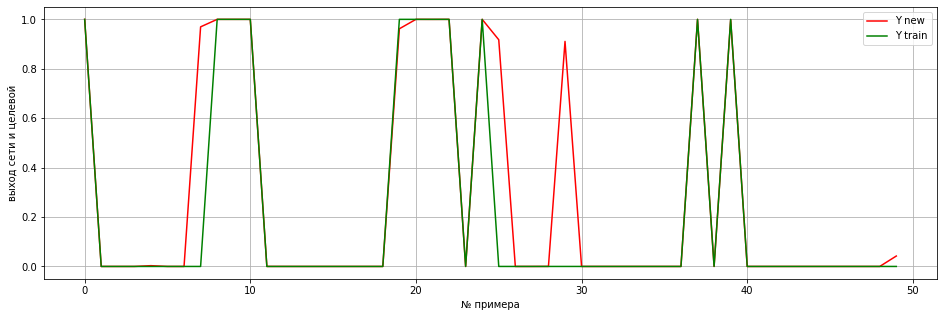

In [214]:
N = 50
plt.figure(figsize=(16, 5))
plt.plot(y_pred[:N, 1], 'r', label='Y new')
plt.plot(y_test[:N, 1], 'g', label='Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.grid()
plt.legend()
plt.show()  # расскоментируйте, чтобы посмотреть

### Построение модели с тремя слоями (2-hidden)

In [215]:

# определим число нейронов скрытого слоя
neuron_numb = 10

# присваевание случайных весов

w0 = 2 * np.random.random((4, neuron_numb)) - 1  # для входного слоя   - 4 входа, 3 выхода
w1 = 2 * np.random.random((neuron_numb, neuron_numb)) - 1  # для внутреннего слоя n x n
w2 = 2 * np.random.random((neuron_numb, 3)) - 1  # для внутреннего слоя - 5 входов, 3 выхода

# скорость обучения (learning rate)
n = 0.05

# массив для ошибок, чтобы потом построить график
errors = []

layer0 = X_train

# процесс обучения
for i in range(10000):
    # прямое распространение(feed forward)
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = sigmoid(np.dot(layer1, w1))
    layer3 = sigmoid(np.dot(layer2, w2))

    # обратное распространение(back propagation) с использованием градиентного спуска
    layer3_error = y_train - layer3  # производная функции потерь = производная квадратичных потерь
    layer3_delta = layer3_error * sigmoid_deriv(layer3)

    layer2_error = layer3_delta.dot(w2.T)
    layer2_delta = layer2_error * sigmoid_deriv(layer2)

    layer1_error = layer2_delta.dot(w1.T)
    layer1_delta = layer1_error * sigmoid_deriv(layer1)

    # коррекция
    w2 += layer1.T.dot(layer3_delta) * n
    w1 += layer1.T.dot(layer2_delta) * n
    w0 += layer0.T.dot(layer1_delta) * n
    # метрика модели
    error = np.mean(np.abs(layer3_error))
    errors.append(error)
    accuracy = (1 - error) * 100

print("Аккуратность нейронной сети " + str(round(accuracy, 2)) + "%")

Аккуратность нейронной сети 97.97%


## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?


## Вывод

1. Модель с 2-мя слоями переведена в ОО-стиль для простоты работы. Определены методы fit и predict
2. Проведен поиск оптимального решения по сетке
   Рекордный результат при: Количество нейронов: 20, Скорость обучения: 0.1, Количество эпох: 20000, Точность - 98.92%
3. Построена модель с 3-слоями

**Основной вывод: чем модель сложнее, тем лучше улавливает нюансы предметной области. Также существенно влияет количество иттераций обучения (эпох).**

#### Дополнительные материалы

<ol>
    <li>https://medium.com/topic/machine-learning</li>
</ol>

#### Используемая литература

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>Глубокое обучение — Николенко С. И., Кадурин 2018</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Asifullah Khan, Anabia Sohail, Umme Zahoora, Aqsa Saeed Qureshi - A Survey of the Recent Architectures of Deep Convolutional Neural Networks 2019</li>
    <li>A direct adaptive method for faster backpropagation learning: the RPROP algorithm - Neural Networks, 1993</li>
    <li>Википедия</li>
    
</ol>